In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,accuracy_score,confusion_matrix,mean_squared_error,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from PIL import Image

os.makedirs('models', exist_ok=True)



Data Preparation

In [3]:
# Load the dataset (replace 'file.csv' with your dataset's file path)
path=os.path.join(os.getcwd(),'data/P1_Churn_Modelling.csv')
# data = pd.read_csv('./data/P1_Churn_Modelling.csv')
data=pd.read_csv(path);
data


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Drop unimportant columns


In [4]:
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
data# they are unique , so they are not important

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Define input and output data

In [6]:
#data input and output
## To features and target
X = data.drop(columns=['Exited'], axis=1)
y = data['Exited']

## Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)




In [7]:

# Get dataset info
print(data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


In [8]:
# Get basic statistics of numerical columns
print(data.describe())


        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769 

In [9]:
# View the shape of the dataset
print("Dataset shape:", data.shape)

Dataset shape: (10000, 11)


Data processing pipeline 


In [11]:
#imputing null values

num_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categ_cols = ['Gender', 'Geography']
#get the lift columns 
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))


## For Numerical
num_pipeline = Pipeline(steps=[
                        ('selector', DataFrameSelector(num_cols)),
                        ('imputer', SimpleImputer(strategy='median')),#handle missing values
                        ('scaler', StandardScaler()),#standardization
                        # ('pca',PCA(n_components=2))
                    ])


## For Categorical
categ_pipeline = Pipeline(steps=[
                        ('selector', DataFrameSelector(categ_cols)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', sparse_output=False))#one hot encoding
                    ])


## For ready cols
ready_pipeline = Pipeline(steps=[
                        ('selector', DataFrameSelector(ready_cols)),
                        ('imputer', SimpleImputer(strategy='most_frequent'))
                    ])



## combine all
all_pipeline = FeatureUnion(transformer_list=[
                                    ('numerical', num_pipeline),
                                    ('categorical', categ_pipeline),
                                    ('ready', ready_pipeline)
                                ])

## apply
X_train_final = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

Resampling

In [12]:
# prepare class_weights for solving imbalance dataset-->second approach
#calculate weights
vals_count = 1 - (np.bincount(y_train) / len(y_train))#number of samples in every class
vals_count = vals_count / np.sum(vals_count)  ## normalizing

#convert weights to a dictionary
dict_weights = {}
for i in range(2):  ## 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

#Using SMOTE for over sampling
over = SMOTE(sampling_strategy=0.7)
X_train_resmapled, y_train_resampled = over.fit_resample(X_train_final, y_train)


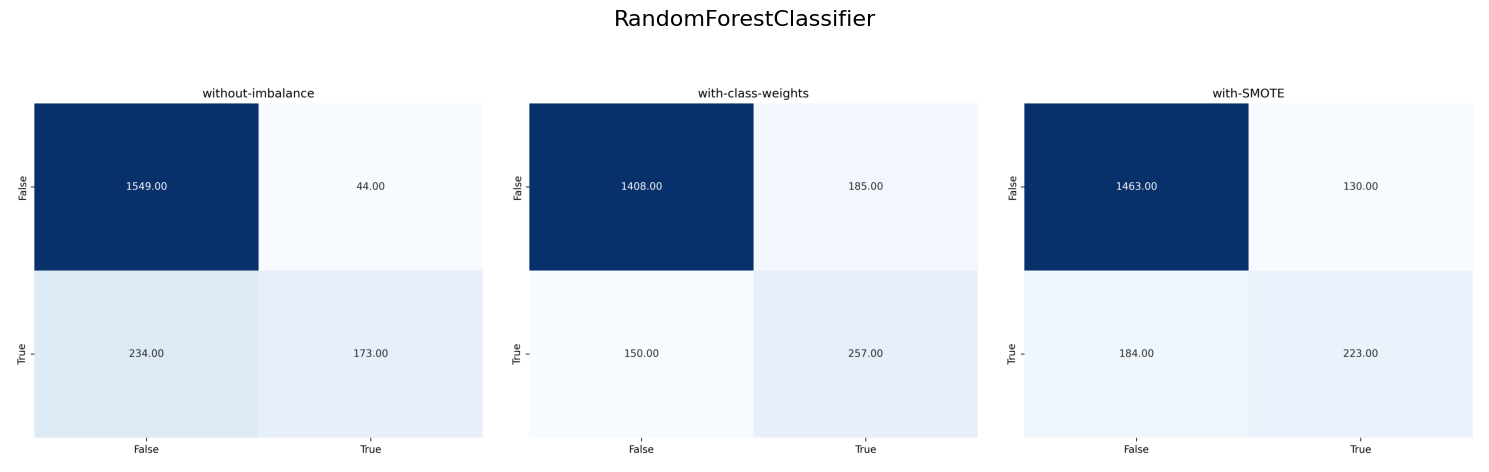

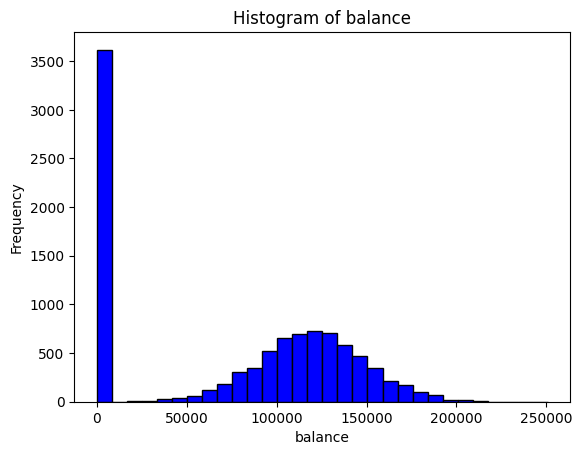

In [13]:

plt.hist(data['Balance'], bins=30, color="blue", edgecolor="black")
plt.xlabel("balance")
plt.ylabel("Frequency")
plt.title("Histogram of balance")
plt.show()

In [14]:
#and may be estimated salary
data['EstimatedSalary'].skew()#it is mild and perfect

np.float64(0.0020853576615585162)

Products skewness


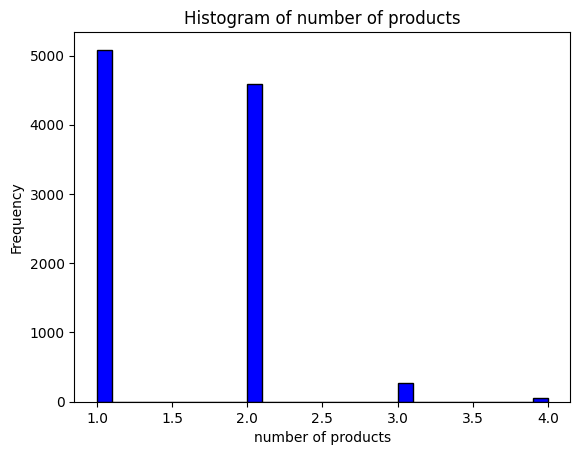

In [15]:
plt.hist(data['NumOfProducts'], bins=30, color="blue", edgecolor="black")
plt.xlabel("number of products")
plt.ylabel("Frequency")
plt.title("Histogram of number of products")
plt.show()

In [16]:
data['NumOfProducts'] = pd.cut(data['NumOfProducts'], bins=3, labels=['small', 'Medium', 'big'])
print(data['NumOfProducts'])

data['NumOfProducts'] = pd.qcut(data['Age'], q=3, labels=['small', 'Medium', 'big'])
print(data)

0        small
1        small
2       Medium
3        small
4        small
         ...  
9995     small
9996     small
9997     small
9998     small
9999     small
Name: NumOfProducts, Length: 10000, dtype: category
Categories (3, object): ['small' < 'Medium' < 'big']
      CreditScore Geography  Gender  Age  Tenure    Balance NumOfProducts  \
0             619    France  Female   42       2       0.00           big   
1             608     Spain  Female   41       1   83807.86        Medium   
2             502    France  Female   42       8  159660.80           big   
3             699    France  Female   39       1       0.00        Medium   
4             850     Spain  Female   43       2  125510.82           big   
...           ...       ...     ...  ...     ...        ...           ...   
9995          771    France    Male   39       5       0.00        Medium   
9996          516    France    Male   35      10   57369.61        Medium   
9997          709    France  Female  

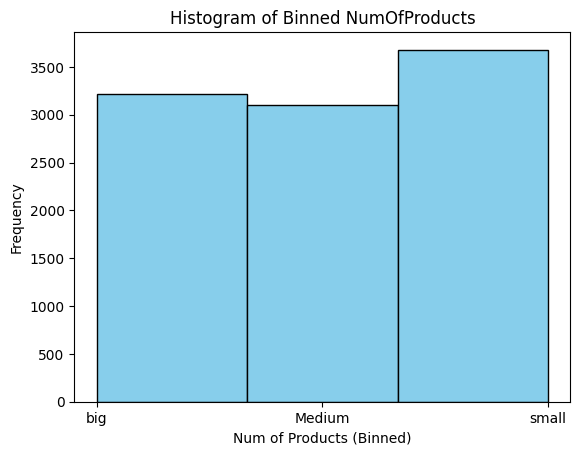

In [17]:
plt.hist(data['NumOfProducts'], bins=3, edgecolor="black", color="skyblue")
plt.xlabel("Num of Products (Binned)")
plt.ylabel("Frequency")
plt.title("Histogram of Binned NumOfProducts")
plt.show()


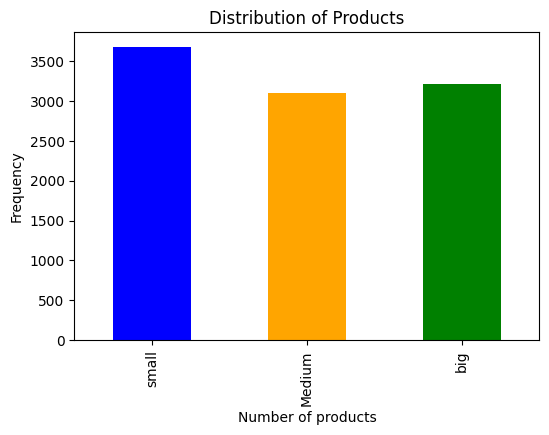

In [18]:
bin_counts = data['NumOfProducts'].value_counts().sort_index()

# Plot the binned categories
plt.figure(figsize=(6,4))
bin_counts.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.xlabel("Number of products")
plt.ylabel("Frequency")
plt.title("Distribution of Products")

plt.show()

In [19]:
data.var(numeric_only=True)

CreditScore        9.341860e+03
Age                1.099941e+02
Tenure             8.364673e+00
Balance            3.893436e+09
HasCrCard          2.077905e-01
IsActiveMember     2.497970e-01
EstimatedSalary    3.307457e+09
Exited             1.622225e-01
dtype: float64


Check for duplicates


In [20]:

duplicates = data.duplicated().sum()
print("Number of duplicate rows:", duplicates)




Number of duplicate rows: 0


In [21]:
data.describe()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,1.00000,1.000000,199992.480000,1.000000


Remove outliers

In [22]:
def remove_outliers(data):
   
    data = data.select_dtypes(include=['number'])
    q1=data.quantile(0.25)
    #print(q1)
    q3=data.quantile(0.75)
    #print(q3)
    iqr=q3-q1
    #print(iqr)
    data[(data<(q1-1.5*iqr))|(data>(q3+1.5*iqr))]=np.nan
    data=data.dropna()
    return data

data=remove_outliers(data)  


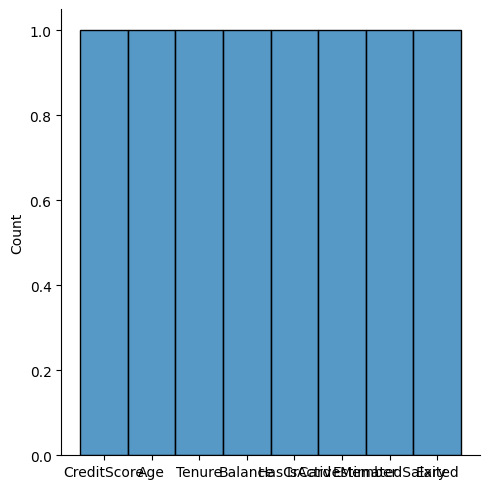

In [23]:
#sns.displot(data[''])#error
sns.displot(data.columns)#exactly

Correlation between features


<Axes: xlabel='Age', ylabel='Balance'>

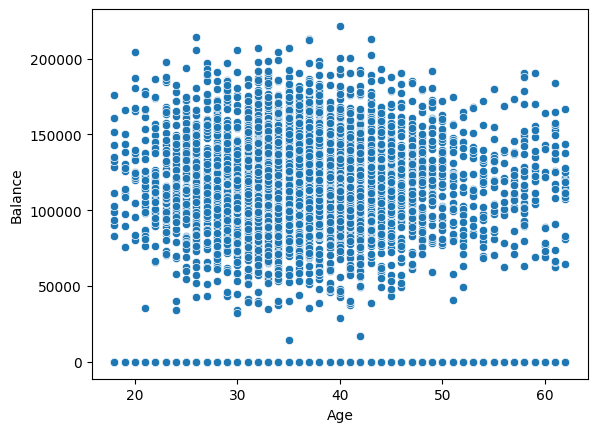

In [36]:
sns.scatterplot(x=data['Age'], y=data['Balance'])



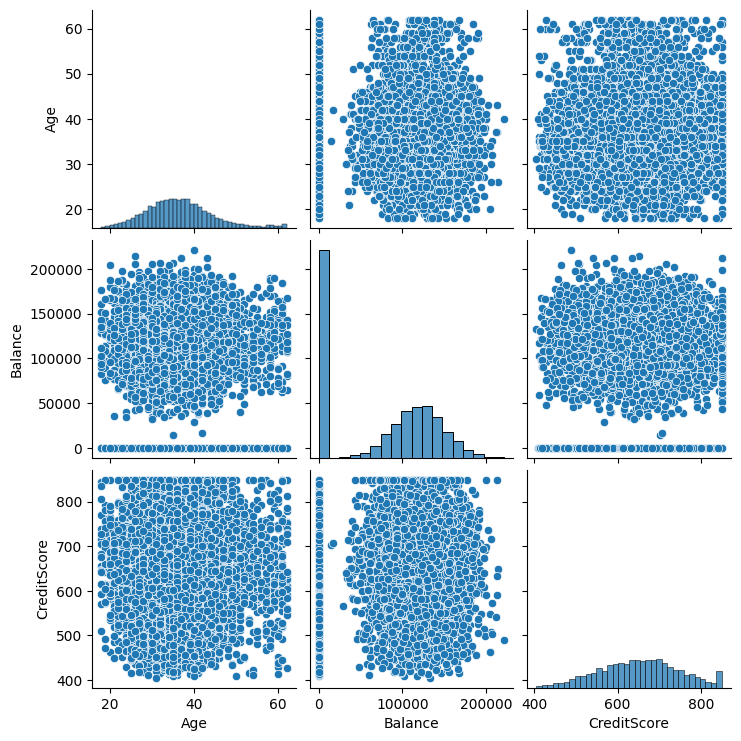

In [24]:
sns.pairplot(data[['Age', 'Balance', 'CreditScore']])  
plt.show()

Compute correlation matrix


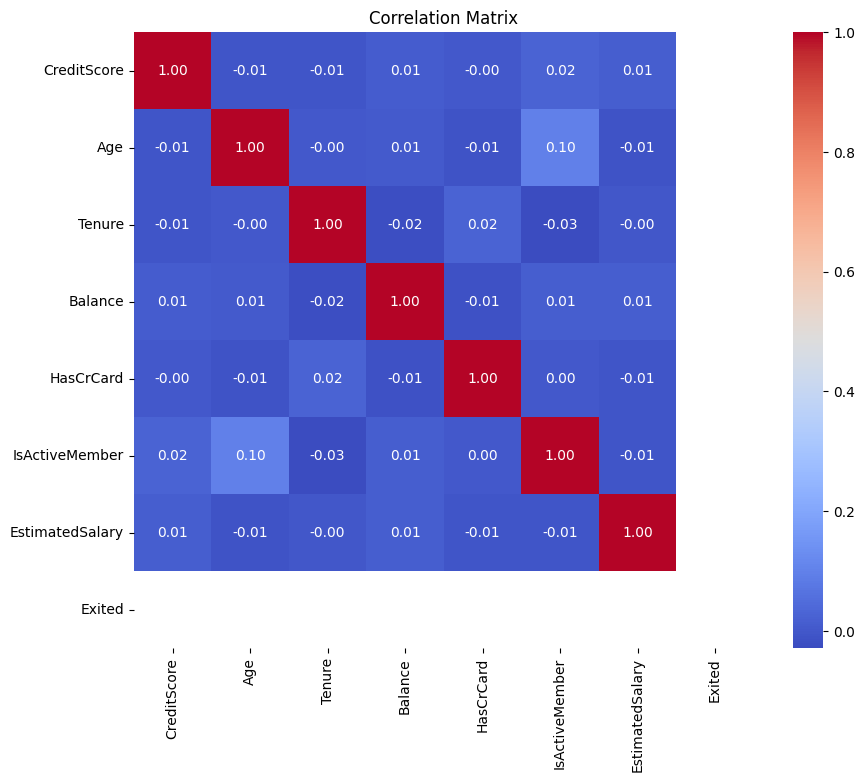

In [25]:
correlation_matrix = data.corr()#it only works with numerical data and you have some categorical
#it doesnt works with so many features like 1000 feature 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Train a model


In [31]:

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=10, random_state=45),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),  # Enable probability for ROC-AUC
    "Decision Tree": DecisionTreeClassifier()
}


with open('output/metrics.txt', 'w') as f:
    pass


def train_model(X_train, y_train, plot_name='', class_weight=None):    
    global clf_name
    results = {}
    clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=45, class_weight=class_weight)
    clf.fit(X_train, y_train)

    #predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test_final)
    
    #computing metrics
    score_train = f1_score(y_train, y_pred_train)
    score_test = f1_score(y_test, y_pred_test)
    score_train_acc = accuracy_score(y_train, y_pred_train)
    score_test_acc = accuracy_score(y_test, y_pred_test)
    
    score_train_precision = precision_score(y_train, y_pred_train)
    score_test_precision = precision_score(y_test, y_pred_test)
    
    score_train_recall = recall_score(y_train, y_pred_train)
    score_test_recall = recall_score(y_test, y_pred_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_final)[:, 1])

    # Mean Squared Error (MSE)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Cross-Validation Scores
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    clf_name = clf.__class__.__name__

#plotting the confustion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cbar=False, fmt='.2f', cmap='Blues')
    plt.title(f'{plot_name}')
    plt.xticks(ticks=np.arange(2) + 0.5, labels=[False, True])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=[False, True])

    ## Save the plot locally
    plt.savefig(f'output/{plot_name}.png', bbox_inches='tight', dpi=300)
    plt.close()
    # Get classification report
    class_report = classification_report(y_test, y_pred_test)
    # Print classification report in the console
    print(f"\nClassification Report for {clf_name} ({plot_name}):\n")
    print(class_report)

    ## Write scores to a file
    with open('output/metrics.txt', 'a') as f:
            f.write(f'{clf_name} {plot_name}\n')
            f.write(f"F1-score of Training is: {score_train*100:.2f} %\n")
            f.write(f"F1-Score of Validation is: {score_test*100:.2f} %\n")
            f.write(f"Accuracy (Train): {score_train_acc*100:.2f} %\n")
            f.write(f"Accuracy (Test): {score_test_acc*100:.2f} %\n")
            f.write(f"Precision (Train): {score_train_precision*100:.2f} %\n")
            f.write(f"Precision (Test): {score_test_precision*100:.2f} %\n")
            f.write(f"Recall (Train): {score_train_recall*100:.2f} %\n")
            f.write(f"Recall (Test): {score_test_recall*100:.2f} %\n")
            f.write(f"ROC-AUC Score: {roc_auc:.4f}\n")
            f.write(f"Mean Squared Error (MSE): {mse_test:.4f}\n")
            f.write(f"Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}\n")
            f.write(f"\nClassification Report:\n{class_report}\n")
            f.write('----'*10 + '\n')
    #save the trained model
    joblib.dump(clf, os.path.join(os.getcwd(), 'models', f'{clf_name}-{plot_name}.pkl'))


    return True



In [33]:

## 1 without  imabalancing data
train_model(X_train=X_train_final, y_train=y_train, plot_name='without-imbalance', class_weight=None)

## 2 with  class_weights
train_model(X_train=X_train_final, y_train=y_train, plot_name='with-class-weights', class_weight=dict_weights)

## 3 with  (SMOTE)
train_model(X_train=X_train_resmapled, y_train=y_train_resampled, plot_name=f'with-SMOTE', class_weight=None)


Classification Report for RandomForestClassifier (without-imbalance):

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.79      0.42      0.55       407

    accuracy                           0.86      2000
   macro avg       0.83      0.69      0.73      2000
weighted avg       0.85      0.86      0.84      2000


Classification Report for RandomForestClassifier (with-class-weights):

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.59      0.63      0.61       407

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.84      0.84      2000


Classification Report for RandomForestClassifier (with-SMOTE):

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.63    

True

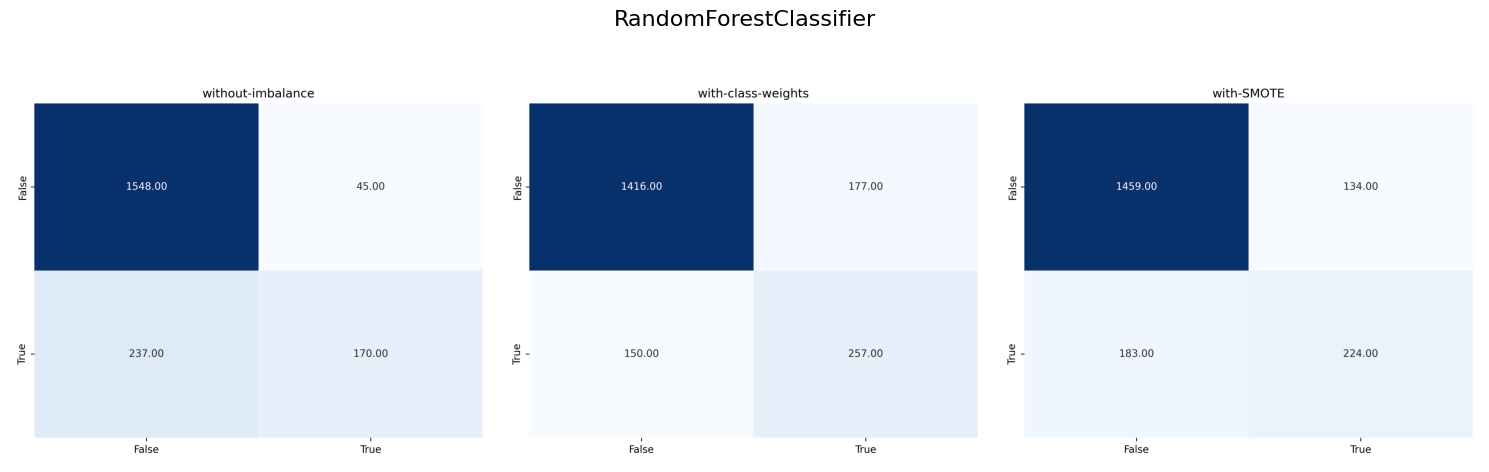

In [34]:
## Combine all conf matrix in one
confusion_matrix_paths = [f'./output/without-imbalance.png', f'./output/with-class-weights.png', f'./output/with-SMOTE.png']

plt.figure(figsize=(15, 5))  
for i, path in enumerate(confusion_matrix_paths, 1):
    img = Image.open(path)
    plt.subplot(1, len(confusion_matrix_paths), i)
    plt.imshow(img)
    plt.axis('off')  


## Save combined plot locally
plt.suptitle(clf_name, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'output/conf_matrix.png', bbox_inches='tight', dpi=300)

## Delete old image files
for path in confusion_matrix_paths:
    os.remove(path)